In [4]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

In [5]:
u_inf = 1.0 

(-1.1, 1.1)

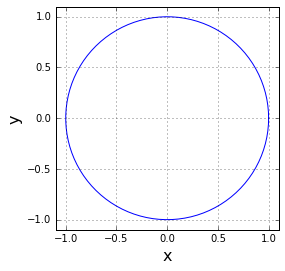

In [6]:
#cylinder geometry 
R = 1.0 #radius of cylinder
theta = numpy.linspace(0, 2*math.pi, 100)
x_cylinder, y_cylinder = R*numpy.cos(theta), R*numpy.sin(theta)

size=4
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=1)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1)

In [7]:
class Panel:
    """Contains information related to a panel"""
    
    def __init__(self, xa, ya, xb, yb):
        
        """Sets the end-points and calculates the center, length, and angle 
        (with the x-axis) of the panel.
        Initializes the strength of the source-sheet, the tangential velocity,
        and the pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)
        
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
            
        self.sigma = 0.
        self.vt = 0.
        self.cp = 0.

(-1.1, 1.1)

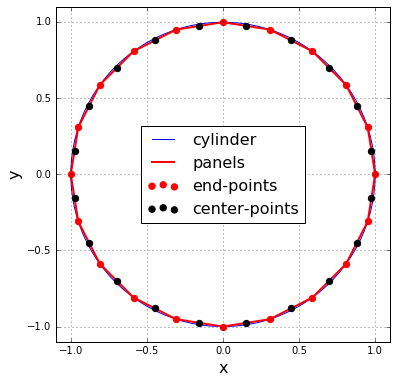

In [20]:
N_panels = 20

x_ends = R*numpy.cos(numpy.linspace(0, 2*math.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0, 2*math.pi, N_panels+1))

panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder, label='cylinder', color='b', linestyle='-', linewidth=1)
pyplot.plot(x_ends, y_ends, label='panels', color='r', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], label='end-points', color='r', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], label='center-points', color='k', s=40, zorder=3)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1)

In [21]:
def integral_normal(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    
    def integrand(s):
        return ( (+(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.cos(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.sin(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [22]:
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5/math.pi*integral_normal(p_i, p_j)
            
b = -u_inf * numpy.cos([p.beta for p in panels])

In [23]:
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]
    

In [24]:
def integral_tangential(p_i, p_j):
    
    def integrand(s):
        return ( (-(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.sin(p_i.beta)+(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.cos(p_i.beta))/
               ((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2+(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [25]:
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/math.pi*integral_tangential(p_i, p_j)

#compute the RHS of the linear system
b = -u_inf*numpy.sin([panel.beta for panel in panels])

#compute the tangential velocity at each panel center-point
vt = numpy.dot(A,sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

In [26]:
#calculate the surface pressure coefficient
for panel in panels:
    panel.cp = 1.0 - (panel.vt/u_inf)**2

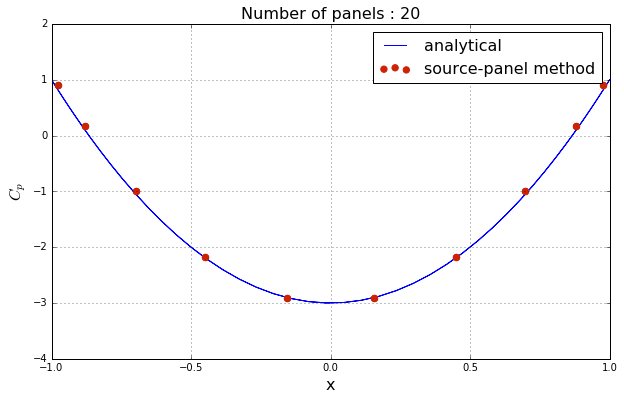

In [27]:
cp_analytical = 1.0 - 4*(y_cylinder/R)**2

# plot the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(x_cylinder, cp_analytical,
            label='analytical',
            color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels],
               label='source-panel method',
               color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.0, 1.0)
pyplot.ylim(-4.0, 2.0);

In [28]:
def integral(x, y, panel, dxdz, dydz):
    
    def integrand(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz + (y- (panel.ya + math.cos(panel.beta)*s)) * dydz) /
                ((x - (panel.xa - math.sin(panel.beta)*s))**2 + (y - (panel.ya + math.cos(panel.beta)*s))**2) ) 
    return integrate.quad(lambda s:integrand(s), 0., panel.length)[0]

(-2.0, 2.0)

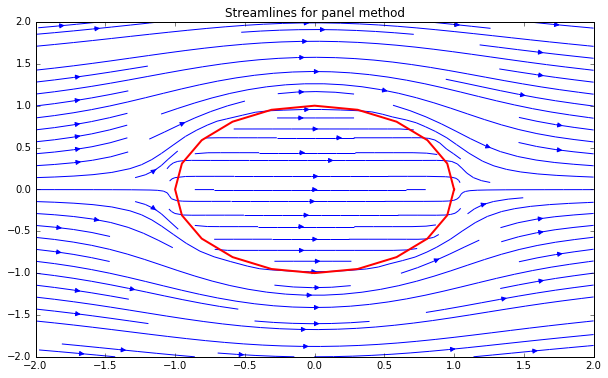

In [30]:
x_start, x_end = -2.0, 2.0 
y_start, y_end = -2.0, 2.0

Np = 30 
alpha = 0.0 

x = numpy.linspace(x_start, x_end, Np)
y = numpy.linspace(y_start, y_end, Np)
X, Y = numpy.meshgrid(x, y)
u, v = numpy.empty_like(X), numpy.empty_like(Y)

for i in range(Np):
    for j in range(Np):
        u[i,j] = u_inf * math.cos(alpha) + 0.5/math.pi * sum([panel.sigma*integral(X[i,j], Y[i,j], panel, 1, 0) for panel in panels])
        
        v[i,j] = u_inf * math.sin(alpha) + 0.5/math.pi * sum([panel.sigma*integral(X[i,j], Y[i,j], panel, 0, 1) for panel in panels])
        
pyplot.figure(figsize=(10, 6))
pyplot.title('Streamlines for panel method')
pyplot.plot(x_ends, y_ends, color='r', linestyle='-', linewidth=2)
pyplot.streamplot(X, Y, u, v)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)